# Introduction to Bamboo

*May 2021*

Bamboo is Python package for modelling the cooling systems of liquid rocket engines. 

Most of its functionality revolves around the bamboo.main.Engine class. Full documentation is available at https://cuspaceflight.github.io/bamboo/.

### Contents: 
- <a href='#Simple Engine Example'>Simple Engine Example</a>
- <a href='#Running a cooling system analysis'>Running a cooling system analysis</a>
- <a href='#Running a stress analysis'>Running a stress analysis</a>

##  <ins> *Simple Engine Example* </ins> <a id='Simple Engine Example'></a>

We will start with an example of creating an Engine. 

To create an Engine object, we need to first create three sub-objects: 
- A <b>PerfectGas</b> object
- A <b>ChamberConditions</b> object
- A <b>Nozzle</b> object

We will first import bamboo and any other modules we need, and will then specify the operating conditions for our engine.

In [1]:
import bamboo as bam
import numpy as np
import matplotlib.pyplot as plt
import thermo

'''Chosen operating points'''
mdot = 4.757        #Mass flow rate (kg/s)
p_amb = 1.01325e5   #Ambient pressure (Pa). 
pc = 10e5           #Chamber pressure (Pa)

'''From ProPEP 3 I got the following data on my exhaust gas'''
gamma = 1.264               #Ratio of specific heats cp/cv (used to specify our PerfectGas object)
molecular_weight = 21.627   #Molecular weight of the exhaust gas (kg/kmol) (used to specify our PerfectGas object)
Tc = 2458.89                #Chamber temperature (K) - obtained from ProPEP 3

### PerfectGas and ChamberConditions

To define our perfect gas, we must specify two of its properties. See the documentation available options. As of writing, the available keyword arguments are 'gamma', 'molecular_weight' and 'cp'.

To define our ChamberConditions, we need the mass flow rate 'mdot', the chamber stagnation pressure 'p0', and the chamber stagnation temperature 'T0'.

In [2]:
perfect_gas = bam.PerfectGas(gamma = gamma, molecular_weight = molecular_weight)
chamber = bam.ChamberConditions(pc, Tc, mdot)

### Nozzle

To define the Nozzle, we have two options. 
- Directly specify the throat and exit area (At and Ae respectively)
- Use the Nozzle.from_engine_components() method, which will select At to just choke the nozzle, and Ae to match a given exit pressure, 'p_amb'. 

NOTE: Area ratio is outside of data range for Rao bell nozzle graphs (minimum 3.7, maximum 47). Using a 15 deg cone nozzle instead.


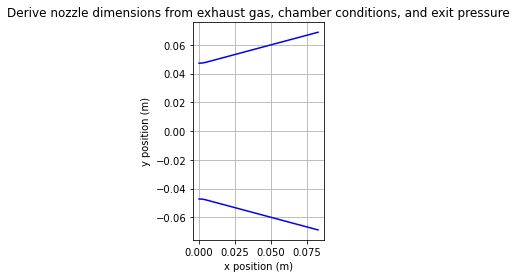

Rao type nozzle (length fraction = 0.8). 
Length = 0.0826365314057112 m 
Throat area = 0.007000596639641742 m^2 
Exit area = 0.014832425713316083 m^2 
Area ratio = 2.1187373700872354 
Rao inflection angle = 14.999999999999998 deg 
Rao exit angle = 14.999999999999998 deg from bamboo (nan deg from Rao graphs) 


In [3]:
#Directly specifying At and Ae

'''
chosen_At = 0.007
chosen_Ae = 0.05

nozzle = bam.Nozzle(chosen_At, chosen_Ae, type = "rao", length_fraction = 0.8)
nozzle.plot_nozzle()
plt.title("Directly specified throat and exit area")
plt.show()
'''

#Deriving Ae and At from the operating conditions and exit pressure
nozzle = bam.Nozzle.from_engine_components(perfect_gas, chamber, p_amb)
nozzle.plot_nozzle()
plt.title("Derive nozzle dimensions from exhaust gas, chamber conditions, and exit pressure")
plt.show()

#Print the nozzle parameters
print(nozzle)

### Creating the Engine object

We can now create the Engine object with relative ease:

In [4]:
engine = bam.Engine(perfect_gas, chamber, nozzle)

We can now get some properties of the Engine:

(note that almost all calculations made with the engine assume isentropic, 1-dimensional, perfect gas relations. Hence, the results may be different to those calculated using reacting flow e.g. from NASA's CEA, or ProPEP).

In [5]:
print(f"Sea level thrust = {engine.thrust(1e5)/1000} kN")
print(f"Sea level Isp = {engine.isp(1e5)} s")

print(f"\nThroat pressure = {engine.p(0)/1e5} bar")
print(f"Throat temperature = {engine.T(0) - 273.15} °C")
print(f"Throat Mach number = {engine.M(0)}")

print(f"\nExit pressure = {engine.p(nozzle.length)/1e5} bar")
print(f"Exit temperature = {engine.T(nozzle.length) - 273.15} °C")
print(f"Exit Mach number = {engine.M(nozzle.length)}")

Sea level thrust = 8.843291394292793 kN
Sea level Isp = 189.5658526560553 s

Throat pressure = 5.523188113751419 bar
Throat temperature = 1899.0143109540631 °C
Throat Mach number = 1.0

Exit pressure = 1.0132499999999893 bar
Exit temperature = 1251.1565550494906 °C
Exit Mach number = 2.1551917585508136


## <ins> *Running a cooling system analysis* </ins> <a id='Running a cooling system analysis'></a>

To run a cooling system analysis, we need to specify the following:
- Transport properties of the exhaust gas (and the coolant if applicable), using the **TransportProperties** class.
- Engine geometry, using **Engine.add_geometry()**.
- Cooling jacket specifications (if applicable), using **Engine.add_cooling_jacket()**.
- Any ablative* liners, using **Engine.add_ablative()**.
- Material properties of the engine wall and any ablatives, using the **Material** class.

*Note that a more appropriate term might be 'refractory'. The actual ablation of 'ablatives' is not modelled right now, so they simply act as thermal insulators.

### Exhaust gas and coolant transport properties

You will need to decide on a way to calculate your exhaust gas and coolant transport properties. <b>CoolProp</b> and <b>thermo</b> are two Python modules that can help with this. In this example we'll use <b>thermo</b>.

You can either choose to use constants for your transport properties (type = 'constants'), or functions (type = 'functions'). If using functions, the function arguments must be in the form <b>func(T, p)</b> where T is the temperature in K and p is pressure in Pa.

In [6]:
#We'll set up a very crude exhaust gas model using thermo.
thermo_gas = thermo.mixture.Mixture(['N2', 'H2O', 'CO2'], zs = [1, 0.2, 0.2])  

#Setup the exhaust gas transport properties
def Pr_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.Prg

def mu_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.mug

def k_gas(T, p):
    thermo_gas.calculate(T, p)
    return thermo_gas.kg

gas_transport = bam.cooling.TransportProperties(type = "functions",
                                                Pr = Pr_gas,
                                                mu = mu_gas,
                                                k = k_gas)

#Set up the coolant transport properties
thermo_coolant = thermo.chemical.Chemical('isopropanol')

def Pr_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.Prl

def mu_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.mul

def k_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.kl

def cp_coolant(T, p):
    #I'm fixing temperature at 320K, because I don't entirely trust thermo's value's for cp
    thermo_coolant.calculate(T = 320, P = p)   
    return thermo_coolant.Cpl

def rho_coolant(T, p):
    thermo_coolant.calculate(T, p)
    return thermo_coolant.rhol

coolant_transport = bam.cooling.TransportProperties(type = "functions",
                                                    Pr = Pr_coolant,
                                                    mu = mu_coolant,
                                                    k = k_coolant,
                                                    cp = cp_coolant,
                                                    rho = rho_coolant)

#Add the gas transport properties to the engine
engine.add_exhaust_transport(gas_transport)

#Coolant transport properties will get used later when creating adding the CoolingJacket to the engine

Alternatively, we can also use constants for our transport properties:

In [7]:
'''
gas_transport = bam.cooling.TransportProperties(type = "constants", 
                                                mu = 7.5e-5, 
                                                k =  0.20, 
                                                Pr = 0.62)

coolant_transport = bam.cooling.TransportProperties(type = "constants", 
                                                    mu = 2.4e-3, 
                                                    k = 0.14, 
                                                    cp = 3000, 
                                                    rho = 800,
                                                    Pr = 7.56)

'''

'\ngas_transport = bam.cooling.TransportProperties(type = "constants", \n                                                mu = 7.5e-5, \n                                                k =  0.20, \n                                                Pr = 0.62)\n\ncoolant_transport = bam.cooling.TransportProperties(type = "constants", \n                                                    mu = 2.4e-3, \n                                                    k = 0.14, \n                                                    cp = 3000, \n                                                    rho = 800,\n                                                    Pr = 7.56)\n\n'

### Engine geometry


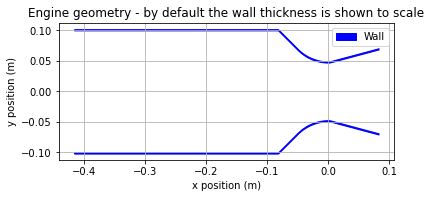

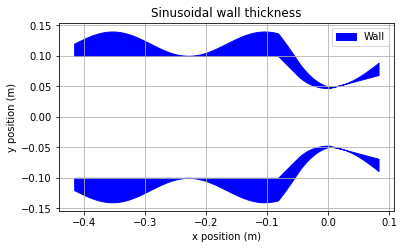

In [8]:
'''Specify the geometry of the engine'''
Ac = np.pi*0.1**2               #Chamber cross-sectional area (m^2) - we'll use a 0.1 m radius.
L_star = 1.5                    #Use the idea of L*: L_star = Volume_c/Area_t
chamber_length = L_star*nozzle.At/Ac
inner_wall_thickness = 2e-3           #Thickness of engine wall (m)

'''Add the geometry to the engine and plot it'''
engine.add_geometry(chamber_length = chamber_length, 
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness)

engine.plot_geometry()
plt.title("Engine geometry - by default the wall thickness is shown to scale")

'''If we want we can specify a variable wall thicknesses'''
#Make an array of equally spaced thickness datapoints
sinusoidal_thickness = 0.02 + 0.02*np.sin(np.linspace(0, 4*np.pi, 100)) 

#The program will stretch the thickness array across the whole engine  
engine.add_geometry(chamber_length = chamber_length, 
                    chamber_area = Ac,
                    inner_wall_thickness = sinusoidal_thickness)
engine.plot_geometry()
plt.title("Sinusoidal wall thickness")
plt.show()

#(Add the normal geometry back for later)
engine.add_geometry(chamber_length = chamber_length, 
                    chamber_area = Ac,
                    inner_wall_thickness = inner_wall_thickness)

### Cooling jacket

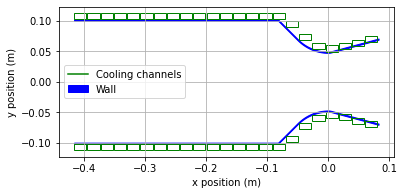

In [9]:
'''Cooling jacket properties'''
inlet_T = 298.15  #Coolant inlet temperature (K)
inlet_p0 = 30e5   #Coolant inlet stagnation pressure (bar)
OF_ratio = 3.5    #Oxidiser/fuel mass ratio
mdot_coolant = mdot/(OF_ratio + 1) #Mass flow rate of coolant
inner_wall_material = bam.materials.CopperC700

'''Add a spiral cooling jacket to the engine'''
#See the documentation for a full list of cooling jacket options
#You can also alternatively use vertical channels, or have the cooling jacket on present over a finite range of the engine.
engine.add_cooling_jacket(inner_wall_material, 
                               inlet_T, 
                               inlet_p0, 
                               coolant_transport, 
                               mdot_coolant, 
                               configuration = "spiral", 
                               channel_width = 0.02,
                               channel_height = 0.01)


#We can see a rough representation of the cooling jacket on the geometry plot 
engine.plot_geometry()
plt.show()

### Ablative*
*note that right now, ablatives are only modelled as thermal insulators. If a wall material is specified for the ablative, it will override the inner wall material specified for the cooling jacket, in the area where the ablative is applied.

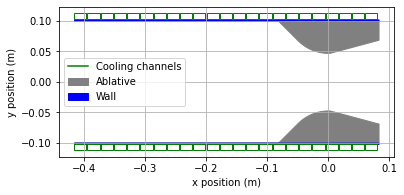

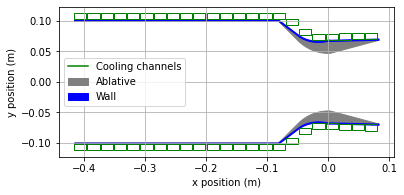

In [10]:
#Choose the material properties for our ablative
ablative_material = bam.materials.Graphite

#Note the 'regression_rate' value doesn't affect anything right now
#By default the program will use an ablative along the whole engine,
#and will fill up the gap between the nozzle contour and chamber radius with ablative
engine.add_ablative(ablative_material,
                    inner_wall_material)

engine.plot_geometry()

#We can also specify the thickness (which can be variable, just like for Engine.add_geometry()), 
#and the range of x values over which we want the ablative to be present

#In this example we make the ablative only present in the nozzle, and make it thickest around the middle.
engine.add_ablative(ablative_material,
                    inner_wall_material,
                    xs = [engine.geometry.x_chamber_end, engine.geometry.x_max],
                    ablative_thickness = [0.0, 0.02, 0.0])

engine.plot_geometry()
plt.show()

#(Replace the ablative with the 1st version - this is the one we'll analyse later)
engine.add_ablative(ablative_material,
                    inner_wall_material)


## Running a steady state heating simulation

We can now run a steady state heating simulation with relative ease. This uses the idea of thermal circuits to find the heat transfer through the wall, and temperatures at each point.

In [11]:
#Run the heating analysis - see the documentation for details on the various arguments.
cooling_data = engine.steady_heating_analysis(h_gas_model = "bartz-sigma", h_coolant_model = "sieder-tate")

#Print of the keys so we can see what data is available
print("")
print(cooling_data.keys())

D:\anaconda3\lib\site-packages\thermo\viscosity.py:826: RuntimeWarning: invalid value encountered in double_scalars
  D = 0.3257/((1.0039-Tr**2.573)**0.2906) - 0.2086


Exported JSON data to 'heating_output.json'

dict_keys(['x', 'q_dot', 'T_ablative_inner', 'T_wall_inner', 'T_wall_outer', 'T_coolant', 'T_gas', 'h_gas', 'h_coolant', 'R_gas', 'R_ablative', 'R_wall', 'R_coolant', 'p_coolant', 'p0_coolant', 'mu_gas', 'k_gas', 'Pr_gas', 'Pr_coolant', 'mu_coolant', 'k_coolant', 'cp_coolant', 'rho_coolant', 'v_coolant'])


Plot the results:

Final x position = -0.4163781058592353
Coolant exit temperature: 469.75678707494797 K


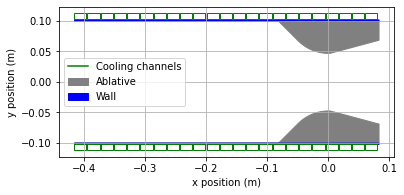

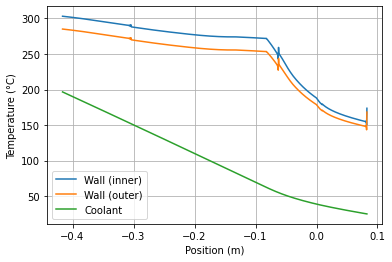

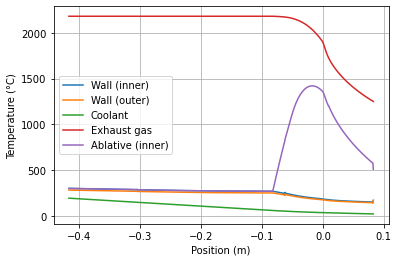

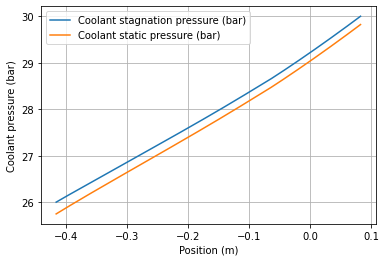

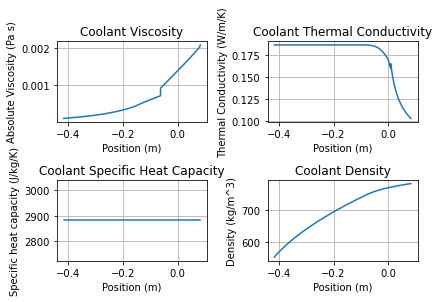

In [12]:
#Print the final coolant temperatures in each case:
print(f"Final x position = {cooling_data['x'][-1]}") 
print(f"Coolant exit temperature: {cooling_data['T_coolant'][-1]} K")

#Plot the geometry again so we can compare it
engine.plot_geometry()

#Use the built in plotting functions to quickly generate some plots
bam.plot.plot_temperatures(cooling_data)
bam.plot.plot_temperatures(cooling_data, show_ablative = True, show_gas = True)

bam.plot.plot_jacket_pressure(cooling_data)
bam.plot.plot_coolant_properties(cooling_data)

##  <ins> *Running a stress analysis* </ins> <a id='Running a stress analysis'></a>

As of now, some stress analysis features don't fully work with spiralling cooling channels. So we'll create a new engine that uses 'vertical' cooling channels instead. 

Additional engine properties need to be specified to run the stress analysis, including:
- Outer wall thickness and material for the cooling jacket


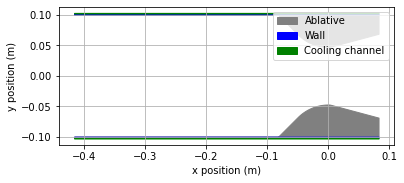

D:\anaconda3\lib\site-packages\thermo\viscosity.py:826: RuntimeWarning: invalid value encountered in double_scalars
  D = 0.3257/((1.0039-Tr**2.573)**0.2906) - 0.2086


In [ ]:
#Respecify the cooling jacket, but this time with the outer wall specified.
outer_wall_material = bam.materials.StainlessSteel304
outer_wall_thickness = 4e-3

engine.add_geometry(chamber_length = chamber_length,
                    chamber_area = Ac, 
                    inner_wall_thickness = inner_wall_thickness, 
                    outer_wall_thickness = outer_wall_thickness)

engine.add_cooling_jacket(inner_wall_material, 
                          inlet_T, 
                          inlet_p0, 
                          coolant_transport, 
                          mdot_coolant, 
                          configuration = "vertical",
                          channel_height = 0.001, 
                          blockage_ratio = 0.5, 
                          number_of_ribs = 20,
                          outer_wall_material = outer_wall_material)

engine.plot_geometry()
plt.show()

new_cooling_data = engine.steady_heating_analysis()

In [ ]:
#Steady state stress analysis
steady_stress = engine.run_stress_analysis(heating_result = new_cooling_data, condition = "steady")

#Transient stress analysis
transient_stress = engine.run_stress_analysis(heating_result = new_cooling_data, condition= "transient", T_amb = inlet_T)

In [ ]:
#Show what keys are available from the resulting data
print("")
print(steady_stress.keys())
print("")
print(transient_stress.keys())

In [ ]:
#Graph results - copied from Henry Free's stress_example.py
xs = new_cooling_data["x"]
threshold = 0.5

#If a hoop or inner expansion stress exceeds this proportion of nominal yield stress,
#then show the nominal yield stress on the plot to make it clear this could be problematic
fig1, axs1 = plt.subplots(figsize=(12, 7))
fig2, axs2 = plt.subplots(figsize=(12, 7))
fig3, axs3 = plt.subplots(figsize=(12, 7))

axs1.plot(xs, steady_stress["thermal_stress"]/1E6, label = "Thermal stress")
axs1.plot(xs, steady_stress["yield_adj"]/1E6, label = "Temperature compensated yield stress")
axs1.set_title("Steady state operation: Inner liner")
axs1.set_xlabel("Axial displacement from throat $(m)$")
axs1.set_ylabel("Stress $(MPa)$")
axs1.set_ylim([0, None])
axs1.legend(bbox_to_anchor = (0, -0.16), loc = "lower left")

axs1_2 = axs1.twinx()
axs1_2.plot(xs, steady_stress["deltaT_wall"], color = "red", label = "Coolant side to chamber side $\Delta T$")
axs1_2.set_ylabel("Temperature difference ($\Delta K$)")
axs1_2.set_ylim([0, None])
axs1_2.legend(bbox_to_anchor = (0, -0.22), loc = "lower left")

fig1.subplots_adjust(bottom = 0.16)

axs2.plot(xs, steady_stress["stress_inner_hoop_steady"]/1E6, label = "Inner liner, prior to ignition")
axs2.plot(xs, transient_stress["stress_inner_hoop_transient"]/1E6, label = "Inner liner, after ignition")
axs2.plot(xs, steady_stress["stress_outer_hoop"]/1E6, label = "Outer liner")
ymax2 = axs2.get_ylim()[1]

if np.max(steady_stress["stress_inner_hoop_steady"]) > threshold*inner_wall_material.sigma_y or \
   np.max(transient_stress["stress_inner_hoop_transient"]) > threshold*inner_wall_material.sigma_y:
    axs2i = axs2.twinx()
    axs2i.get_yaxis().set_visible(False)
    axs2i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax2 = max((ymax2, 1.1*inner_wall_material.sigma_y/1E6))
    axs2i.set_ylim(0, ymax2)
    axs2i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(steady_stress["stress_outer_hoop"]) > threshold*outer_wall_material.sigma_y:
    axs2o = axs2.twinx()
    axs2o.get_yaxis().set_visible(False)
    axs2o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax2 = max((ymax2, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs2i.set_ylim(0, ymax2)
    except NameError:
        pass
    axs2o.set_ylim(0, ymax2)
    axs2o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs2.set_title("Hoop stresses")
axs2.set_xlabel("Axial displacement from throat $(m)$")
axs2.set_ylabel("Stress $(MPa)$")
axs2.legend(bbox_to_anchor = (0, -0.19), loc = "lower left")
axs2.set_ylim([0, ymax2])

fig2.subplots_adjust(bottom = 0.14)

axs3.plot(xs, np.abs(transient_stress["stress_inner_IE"]/1E6), label = "Inner liner")
axs3.plot(xs, np.abs(transient_stress["stress_outer_IE"]/1E6), label = "Outer liner")
ymax3 = axs3.get_ylim()[1]

if np.max(np.abs(transient_stress["stress_inner_IE"])) > threshold*inner_wall_material.sigma_y:
    axs3i = axs3.twinx()
    axs3i.get_yaxis().set_visible(False)
    axs3i.hlines(inner_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "indianred",
                label = "Nominal inner liner yield stress")
    ymax3 = max((ymax3, 1.1*inner_wall_material.sigma_y/1E6))
    axs3i.set_ylim(0, ymax3)
    axs3i.legend(bbox_to_anchor = (0.7, -0.11), loc = "lower left")

if np.max(np.abs(transient_stress["stress_outer_IE"])) > threshold*outer_wall_material.sigma_y:
    axs3o = axs3.twinx()
    axs3o.get_yaxis().set_visible(False)
    axs3o.hlines(outer_wall_material.sigma_y/1E6, xs[0], xs[-1], linestyles = "dashed", color = "maroon",
                label = "Nominal outer liner yield stress")
    ymax3 = max((ymax3, 1.1*outer_wall_material.sigma_y/1E6))
    try:
        axs3i.set_ylim(0, ymax3)
    except NameError:
        pass
    axs3o.set_ylim(0, ymax3)
    axs3o.legend(bbox_to_anchor = (0.7, -0.15), loc = "lower left")

axs3.set_title("Absolute stresses due to constrained inner liner expansion")
axs3.set_xlabel("Axial displacement from throat $(m)$")
axs3.set_ylabel("Stress $(MPa)$")
axs3.legend(bbox_to_anchor = (0, -0.15), loc = "lower left")
axs3.set_ylim([0, ymax3])

fig3.subplots_adjust(bottom = 0.12)

plt.show()